# SciKit Learn Decision Tree Regressor

# Imports

In [14]:
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

# Read data

In [15]:
dataset = pd.read_csv('../dataset/smog_part1.csv', index_col = 0)
dataset = dataset[dataset['humiditySht'] >= 60]

In [16]:
dataset = dataset[['pm25_x', 'pm25_y', 'temperatureSht', 'humiditySht', 'pressure']]
dataset = dataset[dataset['humiditySht'] >= 60]

dataset.head()

,pm25_x,pm25_y,temperatureSht,humiditySht,pressure
0,19.0,13.8,6.1,72,986
1,16.7,14.4,5.9,74,986
2,21.8,15.1,5.7,75,986
3,21.8,18.0,5.7,76,986
4,25.0,19.0,5.5,77,986


# Train and test split

Split data for train and test sets and normalze

In [17]:
Y = dataset['pm25_x'].to_numpy().reshape(-1, 1)
X = dataset.drop('pm25_x', axis = 1).to_numpy()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)

In [19]:
scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = max(y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = y_train / y_scaler
y_test = y_test / y_scaler

# SKLearn Decision Tree Regressor
default values

In [20]:
dtr = DecisionTreeRegressor()

dtr.fit(x_train,y_train)

train_dataset_score = dtr.score(x_train,y_train)
test_dataset_score = dtr.score(x_test, y_test)

print('R2 on train dataset: ', round(train_dataset_score * 100, 2))
print('R2 on test dataset: ', round(test_dataset_score * 100, 2))

R2 on train dataset:  99.94
R2 on test dataset:  85.94


# HalvingGridSearchCV tuner

Running HalvingGridSearch with a full set of parameters as below ends in an error, so I splited the param_grid_full into several sets, the result of which is shown below.

In [21]:
param_grid_full = {
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [2**x for x in range(9)],
    'min_samples_split': [2**x for x in range(9)],
    'min_samples_leaf': [2**x for x in range(9)],
    'max_features': [None, 1.0, 'sqrt', 'log2'],
    'max_leaf_nodes': [2**x for x in range(9)],
    }

param_grid = {
    'criterion': ['absolute_error'],
    'splitter': ['best'],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [2, 4, 8],
    'max_features': [4, 16, 32, 64],
    }

In [269]:
grid_cv_dtr = GridSearchCV(DecisionTreeRegressor(),
                           param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_cv_dtr

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'],
                         'max_features': [4, 16, 32, 64],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8, 16],
                         'splitter': ['best']},
             verbose=1)

In [272]:
%%time
grid_cv_dtr.fit(x_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 553
max_resources_: 14946
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 553
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 16
n_resources: 1659
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 6
n_resources: 4977
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 14931
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 4.29 s, sys: 115 ms, total: 4.41 s
Wall time: 9.13 s


HalvingGridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
                    param_grid={'criterion': ['absolute_error'],
                                'max_features': [4, 16, 32, 64],
                                'min_samples_leaf': [2, 4, 8],
                                'min_samples_split': [2, 4, 8, 16],
                                'splitter': ['best']},
                    verbose=1)

In [273]:
print('Best parameters: ', grid_cv_dtr.best_params_)
print('R2: ', round(grid_cv_dtr.best_score_ * 100, 2))

Best parameters:  {'criterion': 'absolute_error', 'max_features': 4, 'min_samples_leaf': 8, 'min_samples_split': 4, 'splitter': 'best'}
R2:  89.57


### Best found model

In [28]:
dtr = DecisionTreeRegressor(criterion = 'absolute_error',
                            max_features = 4, 
                            min_samples_leaf = 8,
                            min_samples_split = 4, 
                            splitter = 'best')

dtr.fit(x_train,y_train)

DecisionTreeRegressor(criterion='absolute_error', max_features=4,
                      min_samples_leaf=8, min_samples_split=4)

In [27]:
y_pred = dtr.predict(x_test) * y_scaler

r2 = r2_score(y_test * y_scaler, y_pred) * 100
mse = mean_squared_error(y_test * y_scaler, y_pred)
mae = mean_absolute_error(y_test * y_scaler, y_pred)

print('R2: ', r2)
print('MSE: ',mse)
print('MAE: ',mae)

R2:  90.60110899933947
MSE:  4.9222056462403
MAE:  1.0015654268129517


[Text(2232.0, 951.3000000000001, 'pm25_y <= -0.057\nabsolute_error = 0.053\nsamples = 14946\nvalue = 0.08'),
 Text(1116.0, 679.5, 'pm25_y <= -0.675\nabsolute_error = 0.021\nsamples = 8722\nvalue = 0.052'),
 Text(558.0, 407.70000000000005, 'pm25_y <= -0.898\nabsolute_error = 0.01\nsamples = 4242\nvalue = 0.032'),
 Text(279.0, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1674.0, 407.70000000000005, 'pm25_y <= -0.403\nabsolute_error = 0.015\nsamples = 4480\nvalue = 0.071'),
 Text(1395.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1953.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3348.0, 679.5, 'pm25_y <= 1.131\nabsolute_error = 0.052\nsamples = 6224\nvalue = 0.14'),
 Text(2790.0, 407.70000000000005, 'pm25_y <= 0.426\nabsolute_error = 0.03\nsamples = 4492\nvalue = 0.126'),
 Text(2511.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3069.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3906.0, 407.70000000000005, 'pm25_y <= 2.368\nabsolute_er

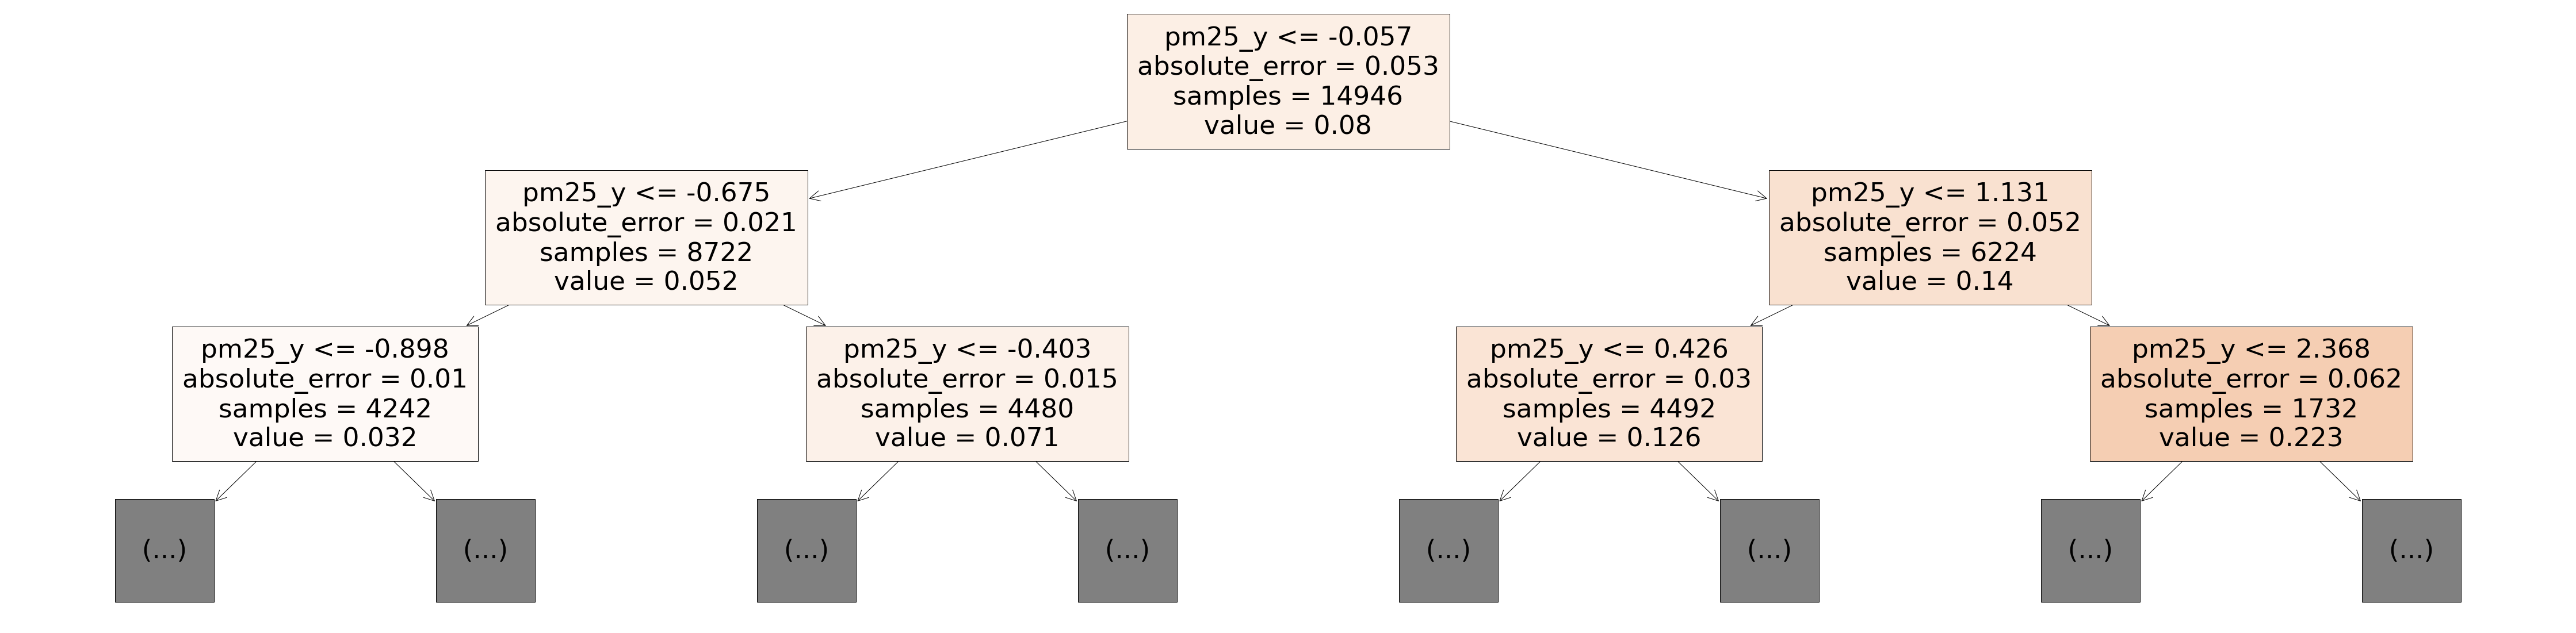

In [29]:
plt.figure(figsize =(80,20))
plot_tree(dtr, feature_names=['pm25_y', 'temperatureSht', 'humiditySht', 'pressure'], max_depth=2, filled=True)

# Searching for parameters step by step

2nd approach: to compare parameters step by step to find the best

Best found parameter: friedman_mse


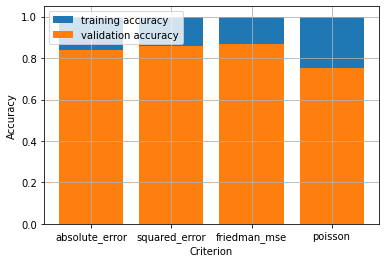

In [30]:
value_range = ['absolute_error', 'squared_error', 'friedman_mse', 'poisson']
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.bar(value_range, training_score, label='training accuracy')
plt.bar(value_range, validation_score, label='validation accuracy')

best_validation_param = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: best


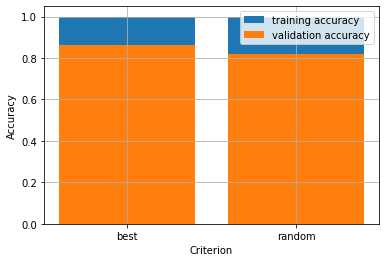

In [31]:
value_range = ['best', 'random']
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.bar(value_range, training_score, label='training accuracy')
plt.bar(value_range, validation_score, label='validation accuracy')

best_validation_param = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 8


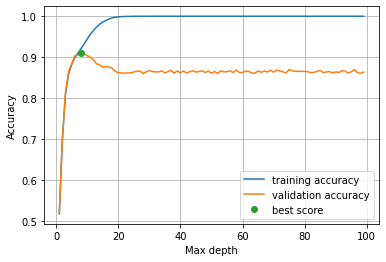

In [32]:
value_range = [i for i in range(1, 100)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 2


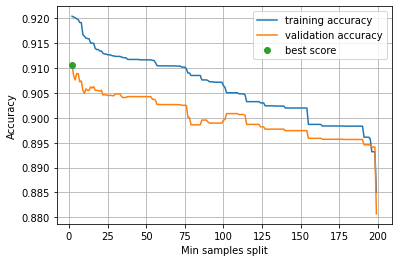

In [33]:
value_range = [i for i in range(2, 200)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Min samples split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 2


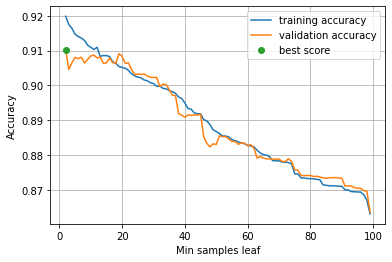

In [34]:
value_range = [i for i in range(2, 100)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2,
                                  min_samples_leaf=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 0.0


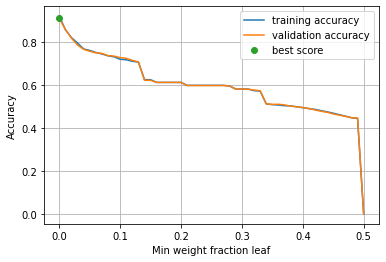

In [35]:
value_range = [i*0.01 for i in range(51)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  min_weight_fraction_leaf=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Min weight fraction leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

1
2
3
4
Best found parameter: 4


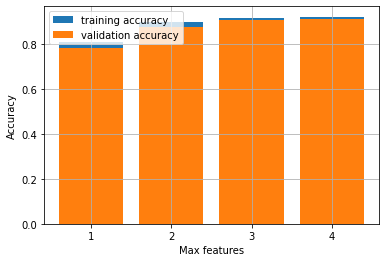

In [41]:
value_range = [1, 2, 3, 4]
training_score = []
validation_score = []

for val in value_range:
    print(val)
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2, 
                                  min_samples_leaf=2,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.bar([str(x) for x in value_range], training_score, label='training accuracy')
plt.bar([str(x) for x in value_range], validation_score, label='validation accuracy')

best_validation_param = value_range[validation_score.index(max(validation_score))]
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Max features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 256


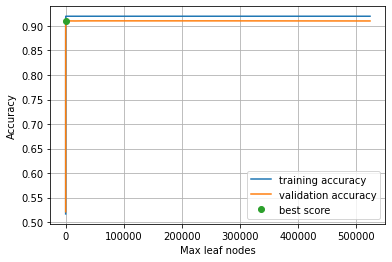

In [42]:
value_range = [2**i for i in range(1, 20)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=4,
                                  max_leaf_nodes=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Max leaf nodes')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 0.0


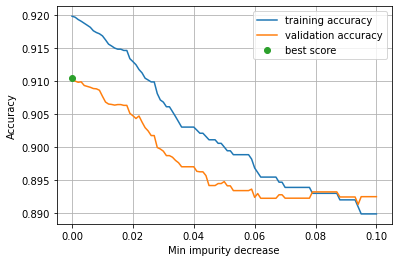

In [43]:
value_range = [i*0.001 for i in range(101)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=4,
                                  max_leaf_nodes=256,
                                  min_impurity_decrease=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('Min impurity decrease')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Best found parameter: 0.0


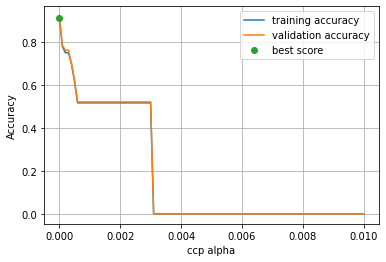

In [44]:
value_range = [i*0.0001 for i in range(101)]
training_score = []
validation_score = []

for val in value_range:
    model = DecisionTreeRegressor(criterion='friedman_mse',
                                  splitter='best',
                                  max_depth=8,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  min_weight_fraction_leaf=0.,
                                  max_features=4,
                                  max_leaf_nodes=256,
                                  min_impurity_decrease=0.,
                                  ccp_alpha=val)
    model.fit(x_train, y_train)
    
    training_score.append(model.score(x_train, y_train))
    validation_score.append(model.score(x_test, y_test))
       
plt.plot(value_range, training_score, label='training accuracy')
plt.plot(value_range, validation_score, label='validation accuracy')

best_validation_score = max(validation_score)
best_validation_param = value_range[validation_score.index(best_validation_score)]
plt.plot(best_validation_param, best_validation_score, 'o', label='best score')
print(f'Best found parameter: {best_validation_param}')

plt.xlabel('ccp alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [45]:
dtr = DecisionTreeRegressor(criterion='friedman_mse',
                              splitter='best',
                              max_depth=8,
                              min_samples_split=2,
                              min_samples_leaf=2,
                              min_weight_fraction_leaf=0.,
                              max_features=4,
                              max_leaf_nodes=256,
                              min_impurity_decrease=0.,
                              ccp_alpha=0.)

dtr.fit(x_train,y_train)

y_pred = dtr.predict(x_test) * y_scaler

r2 = r2_score(y_test * y_scaler, y_pred) * 100
mse = mean_squared_error(y_test * y_scaler, y_pred)
mae = mean_absolute_error(y_test * y_scaler, y_pred)

print('R2: ', r2)
print('MSE: ',mse)
print('MAE: ',mae)

R2:  91.0421756296584
MSE:  4.691218750236143
MAE:  1.0788029692502124


[Text(2232.0, 951.3000000000001, 'pm25_y <= 0.376\nfriedman_mse = 0.006\nsamples = 14946\nvalue = 0.1'),
 Text(1116.0, 679.5, 'pm25_y <= -0.428\nfriedman_mse = 0.001\nsamples = 10807\nvalue = 0.066'),
 Text(558.0, 407.70000000000005, 'pm25_y <= -0.762\nfriedman_mse = 0.001\nsamples = 6197\nvalue = 0.043'),
 Text(279.0, 135.89999999999998, '\n  (...)  \n'),
 Text(837.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1674.0, 407.70000000000005, 'temperatureSht <= -2.116\nfriedman_mse = 0.001\nsamples = 4610\nvalue = 0.095'),
 Text(1395.0, 135.89999999999998, '\n  (...)  \n'),
 Text(1953.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3348.0, 679.5, 'pm25_y <= 1.626\nfriedman_mse = 0.007\nsamples = 4139\nvalue = 0.189'),
 Text(2790.0, 407.70000000000005, 'temperatureSht <= -2.076\nfriedman_mse = 0.003\nsamples = 3064\nvalue = 0.162'),
 Text(2511.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3069.0, 135.89999999999998, '\n  (...)  \n'),
 Text(3906.0, 407.70000000000005, 'pm25_y <= 3.221\nfrie

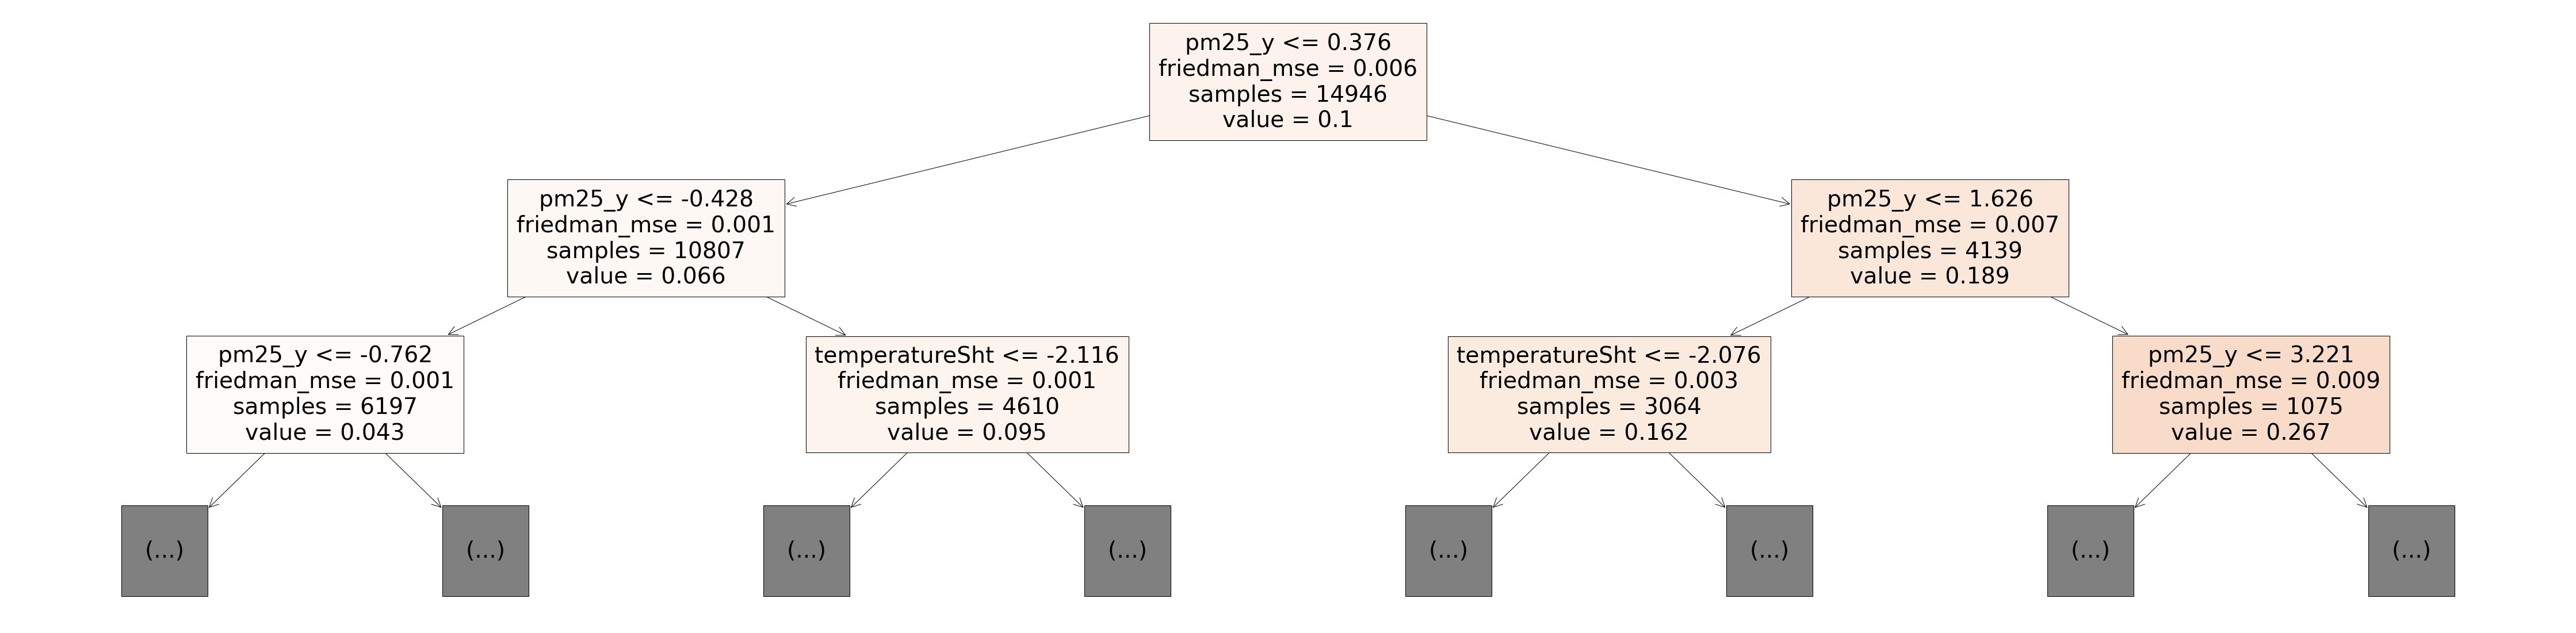

In [46]:
plt.figure(figsize =(80,20))
plot_tree(dtr, feature_names=['pm25_y', 'temperatureSht', 'humiditySht', 'pressure'], max_depth=2, filled=True)